# Include Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import random
import sys
import cv2
import matplotlib
import warnings
import seaborn as sns
import csv
import keras
from numpy import zeros
from matplotlib import pyplot as plt
from datetime import datetime
from subprocess import check_output
from keras.models import Sequential
from keras.utils import print_summary
from keras.layers import Dense, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Dropout, Flatten, TimeDistributed, GRU, GlobalAveragePooling2D
from keras.preprocessing.image import image, ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import roc_curve, roc_auc_score
from keras.utils import print_summary
from keras.layers.recurrent import LSTM
from keras.applications import VGG19, VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.resnet50 import ResNet50
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # showing and rendering figures
from skimage.io import imread
import os
from glob import glob
%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set(style='dark')

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load Datafile

In [2]:
base_image_dir = r'/mnt/disks/user/project/Sample CLAHE'
retina_df = pd.read_csv('trainLabels.csv')
print(retina_df.shape)
retina_df.head()

(35126, 2)


,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


### Load corresponding image path and patient id

In [3]:
#Split the id and loaded it as a PatintId
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
#For sampling weloaded the only 1000 images becaus of teh GPU constraints
retina_df = retina_df.head(1000)
print(retina_df.shape)
retina_df.head()

(1000, 4)


,image,level,PatientId,path
0,10_left,0,10,/mnt/disks/user/project/Sample CLAHE/10_left.jpeg
1,10_right,0,10,/mnt/disks/user/project/Sample CLAHE/10_right....
2,13_left,0,13,/mnt/disks/user/project/Sample CLAHE/13_left.jpeg
3,13_right,0,13,/mnt/disks/user/project/Sample CLAHE/13_right....
4,15_left,1,15,/mnt/disks/user/project/Sample CLAHE/15_left.jpeg


### Validate the image name and the path whether any images are missing

In [4]:
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)

1000 images found of 1000 total


### Load the distribution of the severity

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9bab16208>,
      dtype=object)

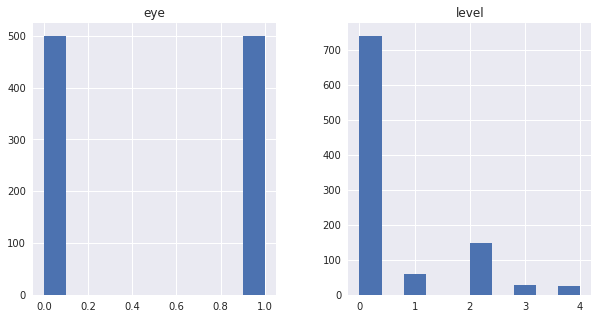

In [5]:
retina_df[['level', 'eye']].hist(figsize = (10, 5))

### Since the data is not balanced and group all severity category into one group
Since in the medical field only status are important not affected and affected 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc930292b38>,
      dtype=object)

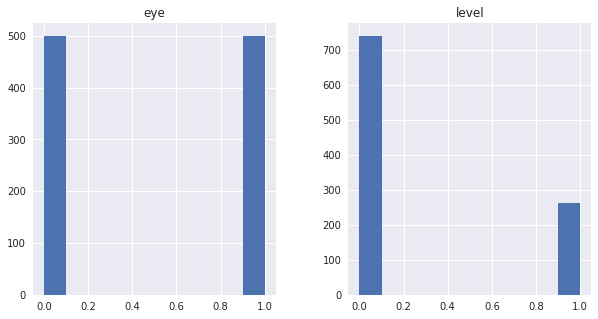

In [6]:
retina_df.loc[retina_df['level'] > 0, 'level'] = 1
#df.to_csv('NewTraining.csv')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
retina_df[['level', 'eye']].hist(figsize = (10, 5))

In [7]:
# Load the categorical value
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))
retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)


,image,level,PatientId,path,exists,eye,level_cat
82,81_left,0,81,/mnt/disks/user/project/Sample CLAHE/81_left.jpeg,True,1,"[1.0, 0.0]"
424,492_left,0,492,/mnt/disks/user/project/Sample CLAHE/492_left....,True,1,"[1.0, 0.0]"
159,190_right,0,190,/mnt/disks/user/project/Sample CLAHE/190_right...,True,0,"[1.0, 0.0]"


### Split the Training and Validation data

In [8]:
from sklearn.model_selection import train_test_split
rr_df = retina_df[['PatientId', 'level']].drop_duplicates()
train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = rr_df['level'])
raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 772 validation 262


### Balance the distribution in the training set

New Data Size: 300 Old Size: 772


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9301d34e0>,
      dtype=object)

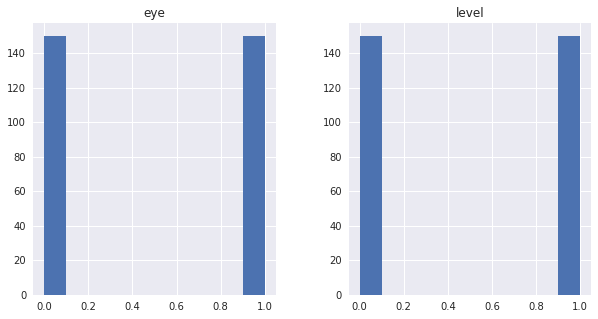

In [9]:
train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(75, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['level', 'eye']].hist(figsize = (10, 5))

### To be removed

In [42]:
retina_df = pd.read_csv('trainLabels.csv')
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir,
                                                         '{}.jpeg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)

retina_df = retina_df.head(3000)
#------------------------------------------------------------------
retina0_df = pd.DataFrame()
retina000_df = pd.DataFrame()
new_retina_df = pd.DataFrame()
retina0_df = retina_df[retina_df['level']==0].head(880)
retina000_df = retina_df[retina_df['level'].isin([2])].head(120)
new_retina_df = new_retina_df.append(retina0_df,ignore_index = True)
new_retina_df = new_retina_df.append(retina000_df,ignore_index = True)
print(new_retina_df.shape)
print(new_retina_df['level'].sum())


5000 images found of 35126 total
(1000, 6)
240


In [43]:
retina_df = new_retina_df
retina_df.loc[retina_df['level'] > 0, 'level'] = 1
pd.DataFrame(retina_df.groupby('level')['image'].count())

retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))
retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)

#------------------------------------------------------------------

from sklearn.model_selection import train_test_split
rr_df = retina_df[['PatientId', 'level']].drop_duplicates()
train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = rr_df['level'])
raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train_df = raw_train_df 
print('Train: ', train_df.shape)
print('Test: ',valid_df.shape)
#retina_df .head()

train 762 validation 252
Train:  (762, 7)
Test:  (252, 7)


In [44]:
# Create the data generation and data augumenattion function 
import tensorflow as tf
from keras import backend as K
from keras.applications.inception_v3 import preprocess_input
import numpy as np

#Loading image from the image path
IMG_SIZE = (512, 512)
def tf_image_loader(out_size, 
                      horizontal_flip = True, 
                      vertical_flip = False, 
                      random_brightness = False,
                      random_contrast = False,
                      random_saturation = False,
                      random_hue = False,
                      color_mode = 'rgb',
                      preproc_func = preprocess_input,
                      on_batch = False):
    def _func(X):
        with tf.name_scope('image_augmentation'):
            with tf.name_scope('input'):
                X = tf.image.decode_png(tf.read_file(X), channels = 3 if color_mode == 'rgb' else 0)
                X = tf.image.resize_images(X, out_size)
            with tf.name_scope('augmentation'):
                if horizontal_flip:
                    X = tf.image.random_flip_left_right(X)
                if vertical_flip:
                    X = tf.image.random_flip_up_down(X)
                if random_brightness:
                    X = tf.image.random_brightness(X, max_delta = 0.1)
                if random_saturation:
                    X = tf.image.random_saturation(X, lower = 0.75, upper = 1.5)
                if random_hue:
                    X = tf.image.random_hue(X, max_delta = 0.15)
                if random_contrast:
                    X = tf.image.random_contrast(X, lower = 0.75, upper = 1.5)
                return preproc_func(X)
    if on_batch: 
        # we are meant to use it on a batch
        def _batch_func(X, y):
            return tf.map_fn(_func, X), y
        return _batch_func
    else:
        # we apply it to everything
        def _all_func(X, y):
            return _func(X), y         
        return _all_func

# Data augmentation 
def tf_augmentor(out_size,
                 intermediate_size = (640, 640),
                 intermediate_trans = 'crop',
                 batch_size = 16,
                 horizontal_flip = True, 
                 vertical_flip = False, 
                 random_brightness = False,
                 random_contrast = False,
                 random_saturation = False,
                 random_hue = False,
                 color_mode = 'rgb',
                 preproc_func = preprocess_input,
                 min_crop_percent = 0.0,
                 max_crop_percent = 0.0,
                 crop_probability = 0.0,
                 rotation_range = 10):
    
    load_ops = tf_image_loader(out_size = intermediate_size, 
                               horizontal_flip=horizontal_flip, 
                               vertical_flip=vertical_flip, 
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               random_saturation = random_saturation,
                               random_hue = random_hue,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)
    #Batch Operations
    def batch_ops(X, y):
        batch_size = tf.shape(X)[0]
        with tf.name_scope('transformation'):
            # Every element is Nx8 tensor, where N is a batch size.
            transforms = []
            identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
            if rotation_range > 0:
                angle_rad = rotation_range / 180 * np.pi
                angles = tf.random_uniform([batch_size], -angle_rad, angle_rad)
                transforms += [tf.contrib.image.angles_to_projective_transforms(angles, intermediate_size[0], intermediate_size[1])]

            if crop_probability > 0:
                crop_pct = tf.random_uniform([batch_size], min_crop_percent, max_crop_percent)
                left = tf.random_uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
                top = tf.random_uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
                crop_transform = tf.stack([
                      crop_pct,
                      tf.zeros([batch_size]), top,
                      tf.zeros([batch_size]), crop_pct, left,
                      tf.zeros([batch_size]),
                      tf.zeros([batch_size])
                  ], 1)
                coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), crop_probability)
                transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
            if len(transforms)>0:
                X = tf.contrib.image.transform(X,
                      tf.contrib.image.compose_transforms(*transforms),
                      interpolation='BILINEAR') # or 'NEAREST'
            if intermediate_trans=='scale':
                X = tf.image.resize_images(X, out_size)
            elif intermediate_trans=='crop':
                X = tf.image.resize_image_with_crop_or_pad(X, out_size[0], out_size[1])
            else:
                raise ValueError('Invalid Operation {}'.format(intermediate_trans))
            return X, y
    def _create_pipeline(in_ds):
        batch_ds = in_ds.map(load_ops, num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_ops)
    return _create_pipeline

In [45]:
def flow_from_dataframe(idg, 
                        in_df, 
                        path_col,
                        y_col, 
                        shuffle = True, 
                        color_mode = 'rgb'):
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values, 
                                                   np.stack(in_df[y_col].values,0)))
    in_len = in_df[path_col].values.shape[0]
    while True:
        if shuffle:
            # shuffle the whole dataset
            files_ds = files_ds.shuffle(in_len) 
        
        next_batch = idg(files_ds).repeat().make_one_shot_iterator().get_next()
        for i in range(max(in_len//32,1)):
            yield K.get_session().run(next_batch)

In [46]:
#Define the batch size
batch_size = 15
core_idg = tf_augmentor(out_size = IMG_SIZE, 
                        color_mode = 'rgb', 
                        vertical_flip = True,
                        crop_probability=0.0,
                        batch_size = batch_size)

valid_idg = tf_augmentor(out_size = IMG_SIZE, color_mode = 'rgb', 
                         crop_probability=0.0, 
                         horizontal_flip = False, 
                         vertical_flip = False, 
                         random_brightness = False,
                         random_contrast = False,
                         random_saturation = False,
                         random_hue = False,
                         rotation_range = 10,
                         batch_size = batch_size)

train_gen = flow_from_dataframe(core_idg, train_df, 
                         path_col = 'path',
                         y_col = 'level_cat')

valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                         path_col = 'path',
                         y_col = 'level_cat')

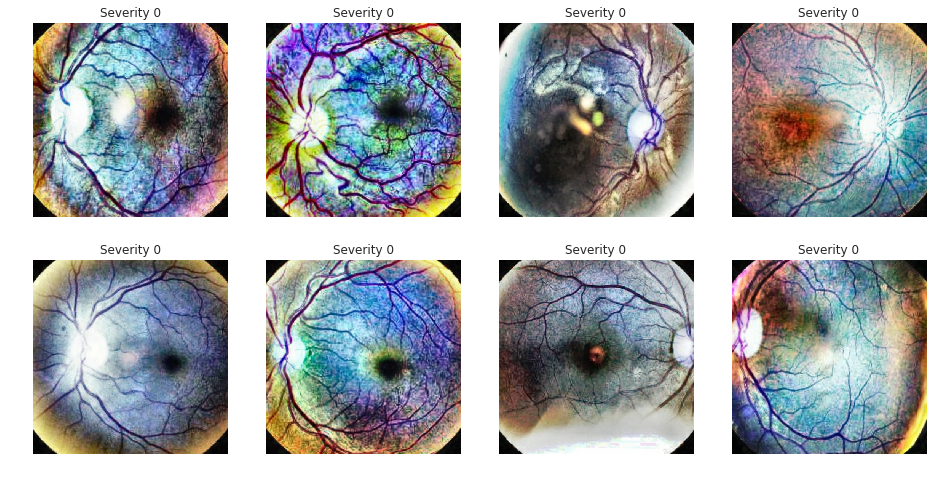

In [47]:
#Generate the training set and load the sample images
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')
    
#print(t_x.shape)
#print(t_y.shape)

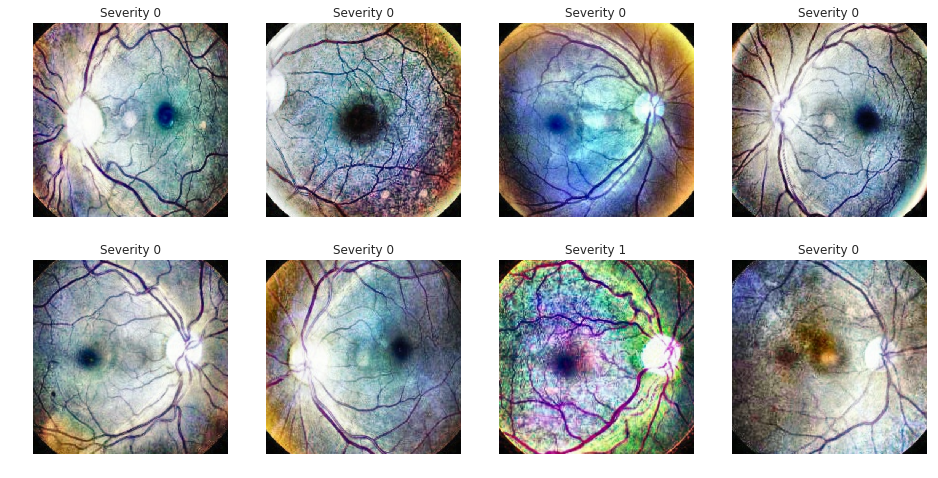

In [48]:
#Generate the validation set and load the sample images
t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')


# Model Builing

# VGG16

58892288/58889256 [==============================] - 5s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 512)       2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        294976    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        1040      
_________________________________________________________________
conv2d_3 (C



Validating the model for the predication accuracy:

240/240 [==============================] - 30s 125ms/step
Accuracy on validation Data: 0.85%


ROC Curve

Here we make an ROC curve for healthy (severity == 0) and sick (severity>0) to see how well the model works at just identifying the disease


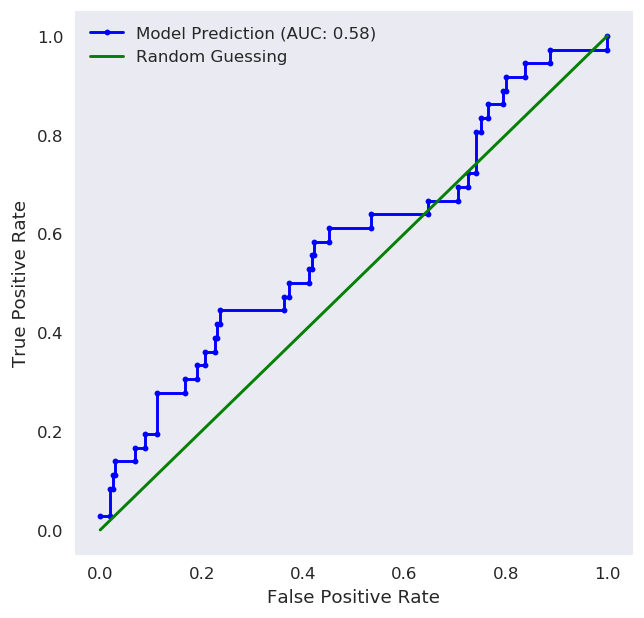

In [17]:
modelName = 'Model 1 - VGG16'
EPOCHS  = 15
from keras.applications.vgg16 import VGG16 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

train_layer = Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
train_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(train_layer)
train_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(train_layer)
train_layer = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(train_layer)

x = Flatten()(train_layer)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
out_layer = Dense(t_y.shape[-1], activation='softmax')(x)


retina_model = Model(inputs = [in_lay], outputs = [out_layer])

from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
#Print Model Summary
retina_model.summary()

#Save Weight and ceating check points for best accuracy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import shutil
if os.path.exists(modelName):
    shutil.rmtree(modelName)

os.mkdir(modelName)
weight_path = modelName +  '/' + modelName + '_retina_weights.best.hdf5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

#!rm -rf ~/.keras # clean up before starting training

#Training Model
print('')
print('Training Model...')
H = retina_model.fit_generator(train_gen, 
                           steps_per_epoch = train_df.shape[0]//batch_size,
                           validation_data = valid_gen, 
                           validation_steps = valid_df.shape[0]//batch_size,
                              epochs = EPOCHS, 
                              callbacks = callbacks_list,
                             workers = 0, # tf-generators are not thread-safe
                             use_multiprocessing=False, 
                             max_queue_size = 0
                            )

# load the best version of the model
retina_model.load_weights(weight_path)
if not os.path.exists(modelName):
    os.mkdir(modelName)
filepath = modelName +  '/' + modelName + '_full_retina_model.h5'
retina_model.save(filepath)

##### create one fixed dataset for evaluating
from tqdm import tqdm_notebook
# fresh valid gen
valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') 
vbatch_count = (valid_df.shape[0]//batch_size-1)
out_size = vbatch_count*batch_size
test_X = np.zeros((out_size,)+t_x.shape[1:], dtype = np.float32)
test_Y = np.zeros((out_size,)+t_y.shape[1:], dtype = np.float32)
for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)), 
                         valid_gen):
    j = i*batch_size
    test_X[j:(j+c_x.shape[0])] = c_x
    test_Y[j:(j+c_x.shape[0])] = c_y
    

#Evaluate the results
#Here we evaluate the results by loading the best version of the model and seeing how the predictions look on the results.
# We then visualize spec and Validating the accuracy
print('')
print('Validating the model for the predication accuracy:')
print('')
from sklearn.metrics import accuracy_score, classification_report
pred_Y = retina_model.predict(test_X, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print('Accuracy on validation Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
#print(classification_report(test_Y_cat, pred_Y_cat))


print('')
print('')
print('ROC Curve')
#ROC Curve
print('')

print('Here we make an ROC curve for healthy (severity == 0) and sick (severity>0) to see how well the model works at just identifying the disease')
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = test_Y_cat>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 120)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

# VGG19

80142336/80134624 [==============================] - 6s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 16, 16, 512)       20024384  
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 512)       2048      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        294976    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 16)        1040      
_________________________________________________________________
conv2d_7 (C



Validating the model for the predication accuracy:

225/225 [==============================] - 16s 73ms/step
Accuracy on validation Data: 0.89%


ROC Curve

Here we make an ROC curve for healthy (severity == 0) and sick (severity>0) to see how well the model works at just identifying the disease


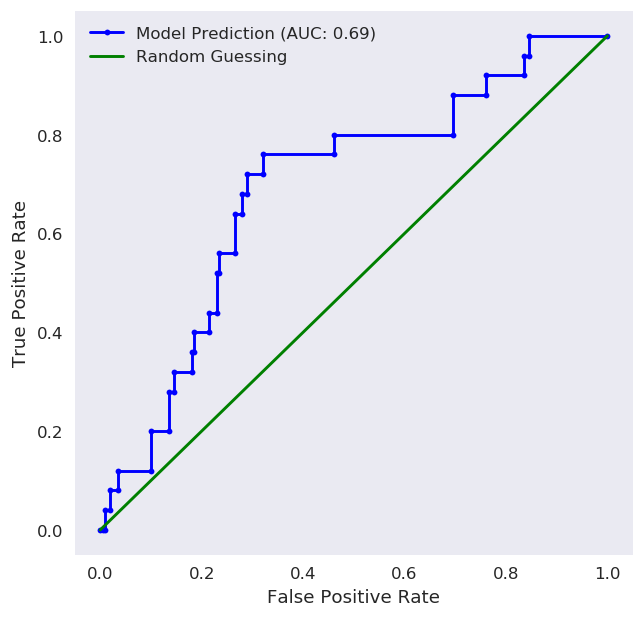

In [25]:
modelName = 'Model 2 - VGG19'
EPOCHS = 15
from keras.applications.vgg19 import VGG19 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

train_layer = Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
train_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(train_layer)
train_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(train_layer)
train_layer = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(train_layer)

x = Flatten()(train_layer)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
out_layer = Dense(t_y.shape[-1], activation='softmax')(x)


retina_model = Model(inputs = [in_lay], outputs = [out_layer])

from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
#Print Model Summary
retina_model.summary()

#Save Weight and ceating check points for best accuracy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import shutil
if os.path.exists(modelName):
    shutil.rmtree(modelName)

os.mkdir(modelName)

weight_path = modelName +  '/' + modelName + '_retina_weights.best.hdf5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

#!rm -rf ~/.keras # clean up before starting training

#Training Model
print('')
print('Training Model...')
H = retina_model.fit_generator(train_gen, 
                           steps_per_epoch = train_df.shape[0]//batch_size,
                           validation_data = valid_gen, 
                           validation_steps = valid_df.shape[0]//batch_size,
                              epochs = EPOCHS, 
                              callbacks = callbacks_list,
                             workers = 0, # tf-generators are not thread-safe
                             use_multiprocessing=False, 
                             max_queue_size = 0
                            )

# load the best version of the model
retina_model.load_weights(weight_path)
if not os.path.exists(modelName):
    os.mkdir(modelName)
filepath = modelName +  '/' + modelName + '_full_retina_model.h5'
retina_model.save(filepath)

##### create one fixed dataset for evaluating
from tqdm import tqdm_notebook
# fresh valid gen
valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') 
vbatch_count = (valid_df.shape[0]//batch_size-1)
out_size = vbatch_count*batch_size
test_X = np.zeros((out_size,)+t_x.shape[1:], dtype = np.float32)
test_Y = np.zeros((out_size,)+t_y.shape[1:], dtype = np.float32)
for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)), 
                         valid_gen):
    j = i*batch_size
    test_X[j:(j+c_x.shape[0])] = c_x
    test_Y[j:(j+c_x.shape[0])] = c_y
    

#Evaluate the results
#Here we evaluate the results by loading the best version of the model and seeing how the predictions look on the results.
# We then visualize spec and Validating the accuracy
print('')
print('Validating the model for the predication accuracy:')
print('')
from sklearn.metrics import accuracy_score, classification_report
pred_Y = retina_model.predict(test_X, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print('Accuracy on validation Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
#print(classification_report(test_Y_cat, pred_Y_cat))


print('')
print('')
print('ROC Curve')
#ROC Curve
print('')

print('Here we make an ROC curve for healthy (severity == 0) and sick (severity>0) to see how well the model works at just identifying the disease')
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = test_Y_cat>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 120)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

# Inception-V3

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
inception_v3 (Model)         (None, 14, 14, 2048)      21802784  
_________________________________________________________________
batch_normalization_193 (Bat (None, 14, 14, 2048)      8192      
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 2048)      0         
_________________________________________________________________
conv2d_205 (Conv2D)          (None, 14, 14, 64)        1179712   
_________________________________________________________________
conv2d_206 (Conv2D)          (None, 14, 14, 16)        1040      
_________________________________________________________________
conv2d_207 (Conv2D)          (None, 14, 14, 8)         136       
__________



Validating the model for the predication accuracy:

225/225 [==============================] - 12s 54ms/step
Accuracy on validation Data: 0.87%


ROC Curve

Here we make an ROC curve for healthy (severity == 0) and sick (severity>0) to see how well the model works at just identifying the disease


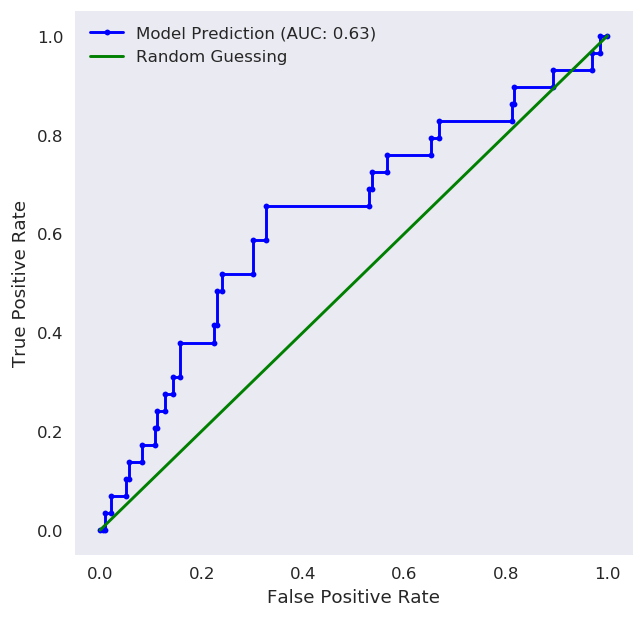

In [49]:
modelName = 'Model 3 - InceptionV3'
EPOCHS = 15
#from keras.applications.vgg16 import VGG16 as PTModel
#from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

train_layer = Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
train_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(train_layer)
train_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(train_layer)
train_layer = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(train_layer)

x = Flatten()(train_layer)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
out_layer = Dense(t_y.shape[-1], activation='softmax')(x)


retina_model = Model(inputs = [in_lay], outputs = [out_layer])

from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
#Print Model Summary
retina_model.summary()

#Save Weight and ceating check points for best accuracy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import shutil
if os.path.exists(modelName):
    shutil.rmtree(modelName)

os.mkdir(modelName)

weight_path = modelName +  '/' + modelName + '_retina_weights.best.hdf5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

#!rm -rf ~/.keras # clean up before starting training

#Training Model
print('')
print('Training Model...')
H = retina_model.fit_generator(train_gen, 
                           steps_per_epoch = train_df.shape[0]//batch_size,
                           validation_data = valid_gen, 
                           validation_steps = valid_df.shape[0]//batch_size,
                              epochs = EPOCHS, 
                              callbacks = callbacks_list,
                             workers = 0, # tf-generators are not thread-safe
                             use_multiprocessing=False, 
                             max_queue_size = 0
                            )


# load the best version of the model
retina_model.load_weights(weight_path)
if not os.path.exists(modelName):
    os.mkdir(modelName)
filepath = modelName +  '/' + modelName + '_full_retina_model.h5'
retina_model.save(filepath)


##### create one fixed dataset for evaluating
from tqdm import tqdm_notebook
# fresh valid gen
valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') 
vbatch_count = (valid_df.shape[0]//batch_size-1)
out_size = vbatch_count*batch_size
test_X = np.zeros((out_size,)+t_x.shape[1:], dtype = np.float32)
test_Y = np.zeros((out_size,)+t_y.shape[1:], dtype = np.float32)
for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)), 
                         valid_gen):
    j = i*batch_size
    test_X[j:(j+c_x.shape[0])] = c_x
    test_Y[j:(j+c_x.shape[0])] = c_y

    

#Evaluate the results
#Here we evaluate the results by loading the best version of the model and seeing how the predictions look on the results.
# We then visualize spec and Validating the accuracy
print('')
print('Validating the model for the predication accuracy:')
print('')
from sklearn.metrics import accuracy_score, classification_report
pred_Y = retina_model.predict(test_X, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print('Accuracy on validation Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
#print(classification_report(test_Y_cat, pred_Y_cat))


print('')
print('')
print('ROC Curve')
#ROC Curve
print('')

print('Here we make an ROC curve for healthy (severity == 0) and sick (severity>0) to see how well the model works at just identifying the disease')
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = test_Y_cat>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 120)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');


# RESNET50

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 16, 16, 2048)      23587712  
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 2048)      8192      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 2048)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        1179712   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 16)        1040      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 8)         136       
__________



Validating the model for the predication accuracy:

225/225 [==============================] - 11s 50ms/step
Accuracy on validation Data: 0.94%


ROC Curve

Here we make an ROC curve for healthy (severity == 0) and sick (severity>0) to see how well the model works at just identifying the disease


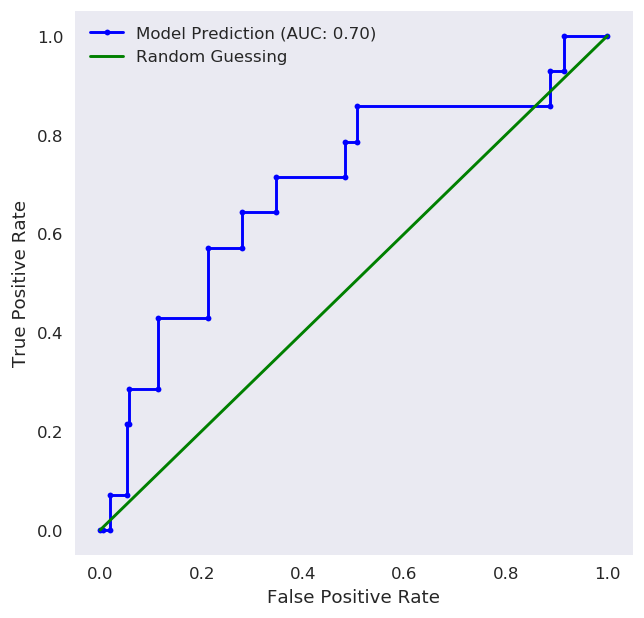

In [17]:
modelName = 'Model 4 - RESNET50'
EPOCHS = 10
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = ResNet50(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

train_layer = Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
train_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(train_layer)
train_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(train_layer)
train_layer = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(train_layer)

x = Flatten()(train_layer)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
out_layer = Dense(t_y.shape[-1], activation='softmax')(x)


retina_model = Model(inputs = [in_lay], outputs = [out_layer])

from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
#Print Model Summary
retina_model.summary()

#Save Weight and ceating check points for best accuracy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

import shutil
if os.path.exists(modelName):
    shutil.rmtree(modelName)

os.mkdir(modelName)

weight_path = modelName +  '/' + modelName + '_retina_weights.best.hdf5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]


if not os.path.exists(modelName):
    os.mkdir(modelName)
    
#Training Model
print('')
print('Training Model...')
H = retina_model.fit_generator(train_gen, 
                           steps_per_epoch = train_df.shape[0]//batch_size,
                           validation_data = valid_gen, 
                           validation_steps = valid_df.shape[0]//batch_size,
                              epochs = EPOCHS, 
                              callbacks = callbacks_list,
                             workers = 0, # tf-generators are not thread-safe
                             use_multiprocessing=False, 
                             max_queue_size = 0
                            )


# load the best version of the model
retina_model.load_weights(weight_path)

filepath = modelName +  '/' + modelName + '_full_retina_model.h5'
retina_model.save(filepath)


print('')
print('Creating one fixed dataset for evaluating...')
##### create one fixed dataset for evaluating
from tqdm import tqdm_notebook
valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') 
vbatch_count = (valid_df.shape[0]//batch_size-1)
out_size = vbatch_count*batch_size
test_X = np.zeros((out_size,)+t_x.shape[1:], dtype = np.float32)
test_Y = np.zeros((out_size,)+t_y.shape[1:], dtype = np.float32)
for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)), 
                         valid_gen):
    j = i*batch_size
    test_X[j:(j+c_x.shape[0])] = c_x
    test_Y[j:(j+c_x.shape[0])] = c_y


#Evaluate the results
#Here we evaluate the results by loading the best version of the model and seeing how the predictions look on the results.
# We then visualize spec and Validating the accuracy
print('')
print('Validating the model for the predication accuracy:')
print('')
from sklearn.metrics import accuracy_score, classification_report
pred_Y = retina_model.predict(test_X, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print('Accuracy on validation Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
#print(classification_report(test_Y_cat, pred_Y_cat))

print('')
print('')
print('ROC Curve')
#ROC Curve
print('')

print('Here we make an ROC curve for healthy (severity == 0) and sick (severity>0) to see how well the model works at just identifying the disease')
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = test_Y_cat>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 120)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');